In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
from keras.engine.topology import Layer

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Concatenate
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras import objectives

In [19]:
class ScaleNormalizer(Layer):
    def __init__(self, **kwargs):
        super(ScaleNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, out_scale, mask=None):
        # softmax to normalize the scaling so this is a probability distribution 
        # these need to sum to 1, as they scale a guassian normal functions which have area 1
        max_scale = K.max(out_scale, axis=1, keepdims=True)
        out_scale = out_scale - max_scale
        out_scale = K.exp(out_scale)
        sum_scale = K.sum(out_scale, axis=1, keepdims=True)
        out_scale =  out_scale / sum_scale
        return out_scale
    
    def compute_output_shape(self, inputShape):
        return inputShape    
        
class MuNormalizer(Layer):
    def __init__(self, numComponents=None, outputDim=None, **kwargs):
        self.numComponents=numComponents
        self.outputDim=outputDim
        super(MuNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, mu, mask=None):
        # means so whatever is ok
        return mu
    
    def compute_output_shape(self, inputShape):
        return inputShape

class SigmaNormalizer(Layer):
    def __init__(self, **kwargs):
        super(SigmaNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, out_sigma, mask=None):
        # sigma *must* be positive, hit it with an expodential which is always >0
        # this will give it prior bias as well
        out_sigma = K.exp(out_sigma)
        return out_sigma
    
    def compute_output_shape(self, inputShape):
        return inputShape

In [17]:
class ProbabilityLayer(Layer):
    def calc_normal(self, x, scale, mu, sigma):
        const = 1 / math.sqrt(2*math.pi)
        var =  (1 / (sigma + 1e-8))
        
        result = x - mu
        result = result * var
        result = -K.square(result)/2
        result = K.exp(result) 
        result = result * scale * var * const

        return result
        
    def __init__(self, **kwargs):
        super(ProbabilityLayer, self).__init__(**kwargs)

    def build(self, inputShapes):
        pass

    def call(self, params, mask=None):
        target = params[0] 
        scale  = params[1] 
        mu     = params[2]
        sigma  = params[3]
        
        result = self.calc_normal(target, scale, mu, sigma)
        result = K.sum(result, axis=1, keepdims=True)
        
        return result
    
    def compute_output_shape(self, inputShapes):
        return (inputShapes[0][0], 1)

In [20]:
numComponents=24
outputDim=1

# network to learn the mixture params 
i = Input(shape=(1,))
x = Dense(128)(i)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(numComponents*3)(x)

# now splice it up into the mixture params
scale = Lambda(lambda x: x[:,:numComponents],                output_shape=(numComponents,))(x)
mu    = Lambda(lambda x: x[:,numComponents:2*numComponents], output_shape=(numComponents,))(x)
sigma = Lambda(lambda x: x[:,2*numComponents:],              output_shape=(numComponents,))(x)

# correct the params into the right ranges/priors
scale = ScaleNormalizer()(scale)
mu    = MuNormalizer(numComponents=numComponents, outputDim=outputDim)(mu)
sigma = SigmaNormalizer()(sigma)

# give us an output tap on the params so we can get an idea of the sanity if needed
model_mix_settings = Model(inputs=i, outputs=[scale,mu,sigma])

# now add the layers that computes probility out from the the mixture functions at the (x,y) point
o = Input(shape=(1,))
x = ProbabilityLayer()([o,scale,mu,sigma])

model_train = Model(inputs=[i,o], outputs=x)
model_train.summary()

opt = Adam(lr=0.001)
model_train.compile(loss='binary_crossentropy',optimizer=opt)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          256         input_5[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 128)          0           dense_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          16512       activation_7[0][0]               
__________________________________________________________________________________________________
activation

In [9]:
sampleSize=2000

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, sampleSize))).T
r_data = np.float32(np.random.normal(size=(sampleSize,1)))
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

In [10]:
target = np.ones((y_data.shape[0], 1))

In [11]:
hist = model_train.fit([x_data, y_data], target, batch_size=x_data.size, epochs=10000, verbose=1)

Epoch 1/10000
2000/2000 [==============================] - 0s 91us/step - loss: 10.3986
Epoch 2/10000
2000/2000 [==============================] - 0s 8us/step - loss: 9.4442
Epoch 3/10000
2000/2000 [==============================] - 0s 7us/step - loss: 8.4772
Epoch 4/10000
2000/2000 [==============================] - 0s 9us/step - loss: 7.7357
Epoch 5/10000
2000/2000 [==============================] - 0s 8us/step - loss: 7.1846
Epoch 6/10000
2000/2000 [==============================] - 0s 7us/step - loss: 6.7624
Epoch 7/10000
2000/2000 [==============================] - 0s 7us/step - loss: 6.4132
Epoch 8/10000
2000/2000 [==============================] - 0s 7us/step - loss: 6.1067
Epoch 9/10000
2000/2000 [==============================] - 0s 9us/step - loss: 5.8285
Epoch 10/10000
2000/2000 [==============================] - 0s 7us/step - loss: 5.5858
Epoch 11/10000
2000/2000 [==============================] - 0s 7us/step - loss: 5.3722
Epoch 12/10000
2000/2000 [========================

Epoch 96/10000
2000/2000 [==============================] - 0s 8us/step - loss: 3.0082
Epoch 97/10000
2000/2000 [==============================] - 0s 8us/step - loss: 3.0021
Epoch 98/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9955
Epoch 99/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9881
Epoch 100/10000
2000/2000 [==============================] - 0s 7us/step - loss: 2.9824
Epoch 101/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9752
Epoch 102/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9692
Epoch 103/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9622
Epoch 104/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9538
Epoch 105/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.9461
Epoch 106/10000
2000/2000 [==============================] - 0s 7us/step - loss: 2.9373
Epoch 107/10000
2000/2000 [=========

2000/2000 [==============================] - 0s 6us/step - loss: 2.1408
Epoch 190/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.1361
Epoch 191/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.1410
Epoch 192/10000
2000/2000 [==============================] - 0s 7us/step - loss: 2.1242
Epoch 193/10000
2000/2000 [==============================] - 0s 7us/step - loss: 2.1322
Epoch 194/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.1152
Epoch 195/10000
2000/2000 [==============================] - 0s 7us/step - loss: 2.1234
Epoch 196/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.1220
Epoch 197/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.1091
Epoch 198/10000
2000/2000 [==============================] - 0s 7us/step - loss: 2.1187
Epoch 199/10000
2000/2000 [==============================] - 0s 6us/step - loss: 2.1364
Epoch 200/10000
2000/2000 [=====================

Epoch 283/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.9268
Epoch 284/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.9159
Epoch 285/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.9089
Epoch 286/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.8899
Epoch 287/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.9347
Epoch 288/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.9503
Epoch 289/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.9894
Epoch 290/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.9019
Epoch 291/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.8938
Epoch 292/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.8878
Epoch 293/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.8971
Epoch 294/10000
2000/2000 [=====

2000/2000 [==============================] - 0s 6us/step - loss: 1.5599
Epoch 377/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5570
Epoch 378/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.5555
Epoch 379/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5523
Epoch 380/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5519
Epoch 381/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5429
Epoch 382/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5337
Epoch 383/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5312
Epoch 384/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.5363
Epoch 385/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.5310
Epoch 386/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5210
Epoch 387/10000
2000/2000 [=====================

Epoch 470/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3437
Epoch 471/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3433
Epoch 472/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3430
Epoch 473/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3426
Epoch 474/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3423
Epoch 475/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3419
Epoch 476/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3416
Epoch 477/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3412
Epoch 478/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3409
Epoch 479/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3405
Epoch 480/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3402
Epoch 481/10000
2000/2000 [=====

2000/2000 [==============================] - 0s 7us/step - loss: 1.3280
Epoch 564/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3264
Epoch 565/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3240
Epoch 566/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3230
Epoch 567/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3232
Epoch 568/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3241
Epoch 569/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3254
Epoch 570/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3256
Epoch 571/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3258
Epoch 572/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3237
Epoch 573/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3222
Epoch 574/10000
2000/2000 [=====================

Epoch 657/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3144
Epoch 658/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3131
Epoch 659/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3125
Epoch 660/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3130
Epoch 661/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.3147
Epoch 662/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3161
Epoch 663/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3179
Epoch 664/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3164
Epoch 665/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3146
Epoch 666/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3125
Epoch 667/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3122
Epoch 668/10000
2000/2000 [=====

2000/2000 [==============================] - 0s 8us/step - loss: 1.3079
Epoch 751/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3083
Epoch 752/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3096
Epoch 753/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3107
Epoch 754/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3113
Epoch 755/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3099
Epoch 756/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3083
Epoch 757/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3065
Epoch 758/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3065
Epoch 759/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3077
Epoch 760/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3087
Epoch 761/10000
2000/2000 [=====================

Epoch 844/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3016
Epoch 845/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3025
Epoch 846/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3031
Epoch 847/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3039
Epoch 848/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3036
Epoch 849/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3035
Epoch 850/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3025
Epoch 851/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3018
Epoch 852/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3019
Epoch 853/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3034
Epoch 854/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3044
Epoch 855/10000
2000/2000 [=====

2000/2000 [==============================] - 0s 6us/step - loss: 1.2993
Epoch 938/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2989
Epoch 939/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2997
Epoch 940/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3018
Epoch 941/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3025
Epoch 942/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.3027
Epoch 943/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3010
Epoch 944/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3024
Epoch 945/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3077
Epoch 946/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3169
Epoch 947/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.3156
Epoch 948/10000
2000/2000 [=====================

Epoch 1030/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3038
Epoch 1031/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3018
Epoch 1032/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2994
Epoch 1033/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2962
Epoch 1034/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2969
Epoch 1035/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2978
Epoch 1036/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2975
Epoch 1037/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2980
Epoch 1038/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2980
Epoch 1039/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2973
Epoch 1040/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2967
Epoch 1041/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2993
Epoch 1123/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3225
Epoch 1124/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3265
Epoch 1125/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2982
Epoch 1126/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3108
Epoch 1127/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3153
Epoch 1128/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3001
Epoch 1129/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3185
Epoch 1130/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3104
Epoch 1131/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2976
Epoch 1132/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.3210
Epoch 1133/10000
2000/2000 [==========

Epoch 1215/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2910
Epoch 1216/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2910
Epoch 1217/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2909
Epoch 1218/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2910
Epoch 1219/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2909
Epoch 1220/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2909
Epoch 1221/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2909
Epoch 1222/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2908
Epoch 1223/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2908
Epoch 1224/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2908
Epoch 1225/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2908
Epoch 1226/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2992
Epoch 1308/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.3064
Epoch 1309/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3030
Epoch 1310/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3016
Epoch 1311/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3101
Epoch 1312/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3020
Epoch 1313/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2995
Epoch 1314/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2980
Epoch 1315/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2987
Epoch 1316/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2926
Epoch 1317/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2937
Epoch 1318/10000
2000/2000 [==========

Epoch 1400/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2869
Epoch 1401/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2868
Epoch 1402/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2869
Epoch 1403/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2873
Epoch 1404/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2879
Epoch 1405/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2887
Epoch 1406/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2899
Epoch 1407/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2912
Epoch 1408/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2935
Epoch 1409/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2955
Epoch 1410/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2952
Epoch 1411/10000
200

2000/2000 [==============================] - 0s 7us/step - loss: 1.2866
Epoch 1493/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2889
Epoch 1494/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2878
Epoch 1495/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2865
Epoch 1496/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2858
Epoch 1497/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2864
Epoch 1498/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2882
Epoch 1499/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2889
Epoch 1500/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2888
Epoch 1501/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2881
Epoch 1502/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2889
Epoch 1503/10000
2000/2000 [==========

Epoch 1585/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2859
Epoch 1586/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2905
Epoch 1587/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2967
Epoch 1588/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2964
Epoch 1589/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2931
Epoch 1590/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2874
Epoch 1591/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2879
Epoch 1592/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2917
Epoch 1593/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2918
Epoch 1594/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2919
Epoch 1595/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2898
Epoch 1596/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2837
Epoch 1678/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2833
Epoch 1679/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2858
Epoch 1680/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2893
Epoch 1681/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2881
Epoch 1682/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2873
Epoch 1683/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2851
Epoch 1684/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2852
Epoch 1685/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2850
Epoch 1686/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2854
Epoch 1687/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2878
Epoch 1688/10000
2000/2000 [==========

Epoch 1770/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2906
Epoch 1771/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2868
Epoch 1772/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2836
Epoch 1773/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2875
Epoch 1774/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2918
Epoch 1775/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2937
Epoch 1776/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2895
Epoch 1777/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2846
Epoch 1778/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2823
Epoch 1779/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2832
Epoch 1780/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2871
Epoch 1781/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2810
Epoch 1863/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2820
Epoch 1864/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2898
Epoch 1865/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2915
Epoch 1866/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2902
Epoch 1867/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2834
Epoch 1868/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2791
Epoch 1869/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2799
Epoch 1870/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2818
Epoch 1871/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2847
Epoch 1872/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2839
Epoch 1873/10000
2000/2000 [==========

Epoch 1955/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2855
Epoch 1956/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2842
Epoch 1957/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2809
Epoch 1958/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2806
Epoch 1959/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2837
Epoch 1960/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2923
Epoch 1961/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2938
Epoch 1962/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2886
Epoch 1963/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2805
Epoch 1964/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2838
Epoch 1965/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2913
Epoch 1966/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2753
Epoch 2048/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2765
Epoch 2049/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2766
Epoch 2050/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2767
Epoch 2051/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2755
Epoch 2052/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2753
Epoch 2053/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2751
Epoch 2054/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2749
Epoch 2055/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2760
Epoch 2056/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2780
Epoch 2057/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2823
Epoch 2058/10000
2000/2000 [==========

Epoch 2140/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2780
Epoch 2141/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2850
Epoch 2142/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2939
Epoch 2143/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2822
Epoch 2144/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2750
Epoch 2145/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2765
Epoch 2146/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2811
Epoch 2147/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2871
Epoch 2148/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2841
Epoch 2149/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2833
Epoch 2150/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2763
Epoch 2151/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2732
Epoch 2233/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2740
Epoch 2234/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2742
Epoch 2235/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2751
Epoch 2236/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2753
Epoch 2237/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2755
Epoch 2238/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2756
Epoch 2239/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2758
Epoch 2240/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2759
Epoch 2241/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2776
Epoch 2242/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2783
Epoch 2243/10000
2000/2000 [==========

Epoch 2325/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2766
Epoch 2326/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2781
Epoch 2327/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2732
Epoch 2328/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2727
Epoch 2329/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2719
Epoch 2330/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2712
Epoch 2331/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2719
Epoch 2332/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2720
Epoch 2333/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2725
Epoch 2334/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2723
Epoch 2335/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2727
Epoch 2336/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2764
Epoch 2418/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2801
Epoch 2419/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2781
Epoch 2420/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2722
Epoch 2421/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2719
Epoch 2422/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2735
Epoch 2423/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2748
Epoch 2424/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2736
Epoch 2425/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2721
Epoch 2426/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2759
Epoch 2427/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2778
Epoch 2428/10000
2000/2000 [==========

Epoch 2510/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2808
Epoch 2511/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2799
Epoch 2512/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2723
Epoch 2513/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2693
Epoch 2514/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2748
Epoch 2515/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2755
Epoch 2516/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2759
Epoch 2517/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2735
Epoch 2518/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2724
Epoch 2519/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2704
Epoch 2520/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2690
Epoch 2521/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2907
Epoch 2603/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2799
Epoch 2604/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2719
Epoch 2605/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2780
Epoch 2606/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2725
Epoch 2607/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2770
Epoch 2608/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2708
Epoch 2609/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2796
Epoch 2610/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2835
Epoch 2611/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2792
Epoch 2612/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2721
Epoch 2613/10000
2000/2000 [==========

Epoch 2695/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2690
Epoch 2696/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2733
Epoch 2697/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2703
Epoch 2698/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2686
Epoch 2699/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2646
Epoch 2700/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2667
Epoch 2701/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2720
Epoch 2702/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2729
Epoch 2703/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2710
Epoch 2704/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2653
Epoch 2705/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2682
Epoch 2706/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2731
Epoch 2788/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2773
Epoch 2789/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2723
Epoch 2790/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2711
Epoch 2791/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2688
Epoch 2792/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2706
Epoch 2793/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2709
Epoch 2794/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2773
Epoch 2795/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2734
Epoch 2796/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2670
Epoch 2797/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2699
Epoch 2798/10000
2000/2000 [==========

Epoch 2880/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2630
Epoch 2881/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2616
Epoch 2882/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2618
Epoch 2883/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2613
Epoch 2884/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2618
Epoch 2885/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2642
Epoch 2886/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2664
Epoch 2887/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2711
Epoch 2888/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2651
Epoch 2889/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2616
Epoch 2890/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2605
Epoch 2891/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2607
Epoch 2973/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2634
Epoch 2974/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2653
Epoch 2975/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2628
Epoch 2976/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2603
Epoch 2977/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2611
Epoch 2978/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2632
Epoch 2979/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2695
Epoch 2980/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2652
Epoch 2981/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2607
Epoch 2982/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2605
Epoch 2983/10000
2000/2000 [==========

Epoch 3065/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2610
Epoch 3066/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2607
Epoch 3067/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2589
Epoch 3068/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2564
Epoch 3069/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2572
Epoch 3070/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2607
Epoch 3071/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2663
Epoch 3072/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2728
Epoch 3073/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2677
Epoch 3074/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2654
Epoch 3075/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2676
Epoch 3076/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2659
Epoch 3158/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2643
Epoch 3159/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2605
Epoch 3160/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2578
Epoch 3161/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2577
Epoch 3162/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2614
Epoch 3163/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2596
Epoch 3164/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2562
Epoch 3165/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2559
Epoch 3166/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2572
Epoch 3167/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2603
Epoch 3168/10000
2000/2000 [==========

Epoch 3250/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2596
Epoch 3251/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2556
Epoch 3252/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2533
Epoch 3253/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2537
Epoch 3254/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2540
Epoch 3255/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2535
Epoch 3256/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2557
Epoch 3257/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2564
Epoch 3258/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2554
Epoch 3259/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2531
Epoch 3260/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2530
Epoch 3261/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2575
Epoch 3343/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2673
Epoch 3344/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2688
Epoch 3345/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2614
Epoch 3346/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2534
Epoch 3347/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2574
Epoch 3348/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2642
Epoch 3349/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2602
Epoch 3350/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2533
Epoch 3351/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2533
Epoch 3352/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2600
Epoch 3353/10000
2000/2000 [==========

Epoch 3435/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2615
Epoch 3436/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2684
Epoch 3437/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2647
Epoch 3438/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2573
Epoch 3439/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2514
Epoch 3440/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2580
Epoch 3441/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2639
Epoch 3442/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2682
Epoch 3443/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2626
Epoch 3444/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2534
Epoch 3445/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2562
Epoch 3446/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2875
Epoch 3528/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.3065
Epoch 3529/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2715
Epoch 3530/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2874
Epoch 3531/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2765
Epoch 3532/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2704
Epoch 3533/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2770
Epoch 3534/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2668
Epoch 3535/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2580
Epoch 3536/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2660
Epoch 3537/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2686
Epoch 3538/10000
2000/2000 [==========

Epoch 3620/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2507
Epoch 3621/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2517
Epoch 3622/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2532
Epoch 3623/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2579
Epoch 3624/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2561
Epoch 3625/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2550
Epoch 3626/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2534
Epoch 3627/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2589
Epoch 3628/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2564
Epoch 3629/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2579
Epoch 3630/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2565
Epoch 3631/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2509
Epoch 3713/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2560
Epoch 3714/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2630
Epoch 3715/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2629
Epoch 3716/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2552
Epoch 3717/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2504
Epoch 3718/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2547
Epoch 3719/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2652
Epoch 3720/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2661
Epoch 3721/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2635
Epoch 3722/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2549
Epoch 3723/10000
2000/2000 [==========

Epoch 3805/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2499
Epoch 3806/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2543
Epoch 3807/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2567
Epoch 3808/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2594
Epoch 3809/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2562
Epoch 3810/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2518
Epoch 3811/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2489
Epoch 3812/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2526
Epoch 3813/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2618
Epoch 3814/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2629
Epoch 3815/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2588
Epoch 3816/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2474
Epoch 3898/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2507
Epoch 3899/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2525
Epoch 3900/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2512
Epoch 3901/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2490
Epoch 3902/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2478
Epoch 3903/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2495
Epoch 3904/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2522
Epoch 3905/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2527
Epoch 3906/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2533
Epoch 3907/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2511
Epoch 3908/10000
2000/2000 [=========

Epoch 3990/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2520
Epoch 3991/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2467
Epoch 3992/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2455
Epoch 3993/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2485
Epoch 3994/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2527
Epoch 3995/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2565
Epoch 3996/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2531
Epoch 3997/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2480
Epoch 3998/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2467
Epoch 3999/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2495
Epoch 4000/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2534
Epoch 4001/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2495
Epoch 4083/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2550
Epoch 4084/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2532
Epoch 4085/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2488
Epoch 4086/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2447
Epoch 4087/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2491
Epoch 4088/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2584
Epoch 4089/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2550
Epoch 4090/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2487
Epoch 4091/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2468
Epoch 4092/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2509
Epoch 4093/10000
2000/2000 [==========

Epoch 4175/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2542
Epoch 4176/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2568
Epoch 4177/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2579
Epoch 4178/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2472
Epoch 4179/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2484
Epoch 4180/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2578
Epoch 4181/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2598
Epoch 4182/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2581
Epoch 4183/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2538
Epoch 4184/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2529
Epoch 4185/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2531
Epoch 4186/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2450
Epoch 4268/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2545
Epoch 4269/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2637
Epoch 4270/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2614
Epoch 4271/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2499
Epoch 4272/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2472
Epoch 4273/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2610
Epoch 4274/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2694
Epoch 4275/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2597
Epoch 4276/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2486
Epoch 4277/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2505
Epoch 4278/10000
2000/2000 [==========

Epoch 4360/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2461
Epoch 4361/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2448
Epoch 4362/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2442
Epoch 4363/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2435
Epoch 4364/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2452
Epoch 4365/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2474
Epoch 4366/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2504
Epoch 4367/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2501
Epoch 4368/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2479
Epoch 4369/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2455
Epoch 4370/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2439
Epoch 4371/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2441
Epoch 4453/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2504
Epoch 4454/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2481
Epoch 4455/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2440
Epoch 4456/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2408
Epoch 4457/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2450
Epoch 4458/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2501
Epoch 4459/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2499
Epoch 4460/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2434
Epoch 4461/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2470
Epoch 4462/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2491
Epoch 4463/10000
2000/2000 [==========

Epoch 4545/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2539
Epoch 4546/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2546
Epoch 4547/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2503
Epoch 4548/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2450
Epoch 4549/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2459
Epoch 4550/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2526
Epoch 4551/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2578
Epoch 4552/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2599
Epoch 4553/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2485
Epoch 4554/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2463
Epoch 4555/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2542
Epoch 4556/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2447
Epoch 4638/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2426
Epoch 4639/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2456
Epoch 4640/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2481
Epoch 4641/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2480
Epoch 4642/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2440
Epoch 4643/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2411
Epoch 4644/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2428
Epoch 4645/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2478
Epoch 4646/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2503
Epoch 4647/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2483
Epoch 4648/10000
2000/2000 [==========

Epoch 4730/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2556
Epoch 4731/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2436
Epoch 4732/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2487
Epoch 4733/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2570
Epoch 4734/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2521
Epoch 4735/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2476
Epoch 4736/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2525
Epoch 4737/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2583
Epoch 4738/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2496
Epoch 4739/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2423
Epoch 4740/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2488
Epoch 4741/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2480
Epoch 4823/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2447
Epoch 4824/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2477
Epoch 4825/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2451
Epoch 4826/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2473
Epoch 4827/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2450
Epoch 4828/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2488
Epoch 4829/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2431
Epoch 4830/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2427
Epoch 4831/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2459
Epoch 4832/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2506
Epoch 4833/10000
2000/2000 [==========

Epoch 4915/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2483
Epoch 4916/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2486
Epoch 4917/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2450
Epoch 4918/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2485
Epoch 4919/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2412
Epoch 4920/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2473
Epoch 4921/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2450
Epoch 4922/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2482
Epoch 4923/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2427
Epoch 4924/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2415
Epoch 4925/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2400
Epoch 4926/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2409
Epoch 5008/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2460
Epoch 5009/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2505
Epoch 5010/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2519
Epoch 5011/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2421
Epoch 5012/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2470
Epoch 5013/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2480
Epoch 5014/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2445
Epoch 5015/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2416
Epoch 5016/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2459
Epoch 5017/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2436
Epoch 5018/10000
2000/2000 [==========

Epoch 5100/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2382
Epoch 5101/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2358
Epoch 5102/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2384
Epoch 5103/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2426
Epoch 5104/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2415
Epoch 5105/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2369
Epoch 5106/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2351
Epoch 5107/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2372
Epoch 5108/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2400
Epoch 5109/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2400
Epoch 5110/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2368
Epoch 5111/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2365
Epoch 5193/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2367
Epoch 5194/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2358
Epoch 5195/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2347
Epoch 5196/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2359
Epoch 5197/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2379
Epoch 5198/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2389
Epoch 5199/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2359
Epoch 5200/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2333
Epoch 5201/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2340
Epoch 5202/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2377
Epoch 5203/10000
2000/2000 [==========

Epoch 5285/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2473
Epoch 5286/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2399
Epoch 5287/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2339
Epoch 5288/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2362
Epoch 5289/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2408
Epoch 5290/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2402
Epoch 5291/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2348
Epoch 5292/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2329
Epoch 5293/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2364
Epoch 5294/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2390
Epoch 5295/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2367
Epoch 5296/10000
2000

2000/2000 [==============================] - 0s 9us/step - loss: 1.2416
Epoch 5378/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2367
Epoch 5379/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2359
Epoch 5380/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2446
Epoch 5381/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2511
Epoch 5382/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2501
Epoch 5383/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2385
Epoch 5384/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2368
Epoch 5385/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2482
Epoch 5386/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2476
Epoch 5387/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2453
Epoch 5388/10000
2000/2000 [==========

Epoch 5470/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2334
Epoch 5471/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2328
Epoch 5472/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2327
Epoch 5473/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2332
Epoch 5474/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2349
Epoch 5475/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2379
Epoch 5476/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2374
Epoch 5477/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2360
Epoch 5478/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2331
Epoch 5479/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2323
Epoch 5480/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2317
Epoch 5481/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2387
Epoch 5563/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2404
Epoch 5564/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2426
Epoch 5565/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2344
Epoch 5566/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2325
Epoch 5567/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2388
Epoch 5568/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2454
Epoch 5569/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2454
Epoch 5570/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2358
Epoch 5571/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2352
Epoch 5572/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2421
Epoch 5573/10000
2000/2000 [==========

Epoch 5655/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2395
Epoch 5656/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2451
Epoch 5657/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2384
Epoch 5658/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2373
Epoch 5659/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2401
Epoch 5660/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2438
Epoch 5661/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2364
Epoch 5662/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2384
Epoch 5663/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2336
Epoch 5664/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2364
Epoch 5665/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2336
Epoch 5666/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2398
Epoch 5748/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2429
Epoch 5749/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2394
Epoch 5750/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2320
Epoch 5751/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2310
Epoch 5752/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2347
Epoch 5753/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2390
Epoch 5754/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2416
Epoch 5755/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2395
Epoch 5756/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2338
Epoch 5757/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2300
Epoch 5758/10000
2000/2000 [==========

Epoch 5840/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2357
Epoch 5841/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2316
Epoch 5842/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2301
Epoch 5843/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2328
Epoch 5844/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2338
Epoch 5845/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2346
Epoch 5846/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2300
Epoch 5847/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2314
Epoch 5848/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2318
Epoch 5849/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2357
Epoch 5850/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2365
Epoch 5851/10000
2000

2000/2000 [==============================] - 0s 5us/step - loss: 1.2325
Epoch 5933/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2305
Epoch 5934/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2327
Epoch 5935/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2330
Epoch 5936/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2323
Epoch 5937/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2306
Epoch 5938/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2311
Epoch 5939/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2317
Epoch 5940/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2321
Epoch 5941/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2294
Epoch 5942/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2303
Epoch 5943/10000
2000/2000 [==========

Epoch 6025/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2354
Epoch 6026/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2321
Epoch 6027/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2275
Epoch 6028/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2286
Epoch 6029/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2329
Epoch 6030/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2336
Epoch 6031/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2320
Epoch 6032/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2297
Epoch 6033/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2306
Epoch 6034/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2324
Epoch 6035/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2322
Epoch 6036/10000
2000

Epoch 6117/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2310
Epoch 6118/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2317
Epoch 6119/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2353
Epoch 6120/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2367
Epoch 6121/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2306
Epoch 6122/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2284
Epoch 6123/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2339
Epoch 6124/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2366
Epoch 6125/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2339
Epoch 6126/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2299
Epoch 6127/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2280
Epoch 6128/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2249
Epoch 6210/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2253
Epoch 6211/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2264
Epoch 6212/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2277
Epoch 6213/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2282
Epoch 6214/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2279
Epoch 6215/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2277
Epoch 6216/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2278
Epoch 6217/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2285
Epoch 6218/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2275
Epoch 6219/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2262
Epoch 6220/10000
2000/2000 [==========

Epoch 6302/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2305
Epoch 6303/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2319
Epoch 6304/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2288
Epoch 6305/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2282
Epoch 6306/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2315
Epoch 6307/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2329
Epoch 6308/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2284
Epoch 6309/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2254
Epoch 6310/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2294
Epoch 6311/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2343
Epoch 6312/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2340
Epoch 6313/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2277
Epoch 6395/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2247
Epoch 6396/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2230
Epoch 6397/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2246
Epoch 6398/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2277
Epoch 6399/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2293
Epoch 6400/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2279
Epoch 6401/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2235
Epoch 6402/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2241
Epoch 6403/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2286
Epoch 6404/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2313
Epoch 6405/10000
2000/2000 [==========

Epoch 6487/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2263
Epoch 6488/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2245
Epoch 6489/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2254
Epoch 6490/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2276
Epoch 6491/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2272
Epoch 6492/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2236
Epoch 6493/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2228
Epoch 6494/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2264
Epoch 6495/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2296
Epoch 6496/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2287
Epoch 6497/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2273
Epoch 6498/10000
2000

Epoch 6580/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2425
Epoch 6581/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2304
Epoch 6582/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2284
Epoch 6583/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2372
Epoch 6584/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2470
Epoch 6585/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2465
Epoch 6586/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2470
Epoch 6587/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2356
Epoch 6588/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2367
Epoch 6589/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2520
Epoch 6590/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2424
Epoch 6591/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2248
Epoch 6673/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2230
Epoch 6674/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2213
Epoch 6675/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2226
Epoch 6676/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2257
Epoch 6677/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2260
Epoch 6678/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2234
Epoch 6679/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2225
Epoch 6680/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2261
Epoch 6681/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2293
Epoch 6682/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2255
Epoch 6683/10000
2000/2000 [==========

Epoch 6765/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2240
Epoch 6766/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2241
Epoch 6767/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2246
Epoch 6768/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2272
Epoch 6769/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2291
Epoch 6770/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2298
Epoch 6771/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2270
Epoch 6772/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2244
Epoch 6773/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2246
Epoch 6774/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2266
Epoch 6775/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2265
Epoch 6776/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2286
Epoch 6858/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2263
Epoch 6859/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2225
Epoch 6860/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2197
Epoch 6861/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2214
Epoch 6862/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2249
Epoch 6863/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2250
Epoch 6864/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2230
Epoch 6865/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2221
Epoch 6866/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2245
Epoch 6867/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2270
Epoch 6868/10000
2000/2000 [==========

Epoch 6950/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2213
Epoch 6951/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2215
Epoch 6952/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2229
Epoch 6953/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2250
Epoch 6954/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2257
Epoch 6955/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2246
Epoch 6956/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2208
Epoch 6957/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2197
Epoch 6958/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2216
Epoch 6959/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2242
Epoch 6960/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2253
Epoch 6961/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2209
Epoch 7043/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2233
Epoch 7044/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2228
Epoch 7045/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2213
Epoch 7046/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2200
Epoch 7047/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2220
Epoch 7048/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2231
Epoch 7049/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2218
Epoch 7050/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2186
Epoch 7051/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2185
Epoch 7052/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2213
Epoch 7053/10000
2000/2000 [==========

Epoch 7135/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2232
Epoch 7136/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2267
Epoch 7137/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2256
Epoch 7138/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2241
Epoch 7139/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2222
Epoch 7140/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2215
Epoch 7141/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2217
Epoch 7142/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2231
Epoch 7143/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2252
Epoch 7144/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2264
Epoch 7145/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2272
Epoch 7146/10000
2000

Epoch 7227/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2175
Epoch 7228/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2185
Epoch 7229/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2180
Epoch 7230/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2174
Epoch 7231/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2176
Epoch 7232/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2190
Epoch 7233/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2220
Epoch 7234/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2236
Epoch 7235/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2246
Epoch 7236/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2230
Epoch 7237/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2210
Epoch 7238/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2193
Epoch 7320/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2171
Epoch 7321/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2213
Epoch 7322/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2249
Epoch 7323/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2233
Epoch 7324/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2215
Epoch 7325/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2196
Epoch 7326/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2194
Epoch 7327/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2197
Epoch 7328/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2202
Epoch 7329/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2214
Epoch 7330/10000
2000/2000 [==========

Epoch 7412/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2181
Epoch 7413/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2180
Epoch 7414/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2211
Epoch 7415/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2239
Epoch 7416/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2207
Epoch 7417/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2188
Epoch 7418/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2173
Epoch 7419/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2190
Epoch 7420/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2216
Epoch 7421/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2193
Epoch 7422/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2190
Epoch 7423/10000
200

2000/2000 [==============================] - 0s 6us/step - loss: 1.2206
Epoch 7505/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2206
Epoch 7506/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2160
Epoch 7507/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2157
Epoch 7508/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2187
Epoch 7509/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2209
Epoch 7510/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2216
Epoch 7511/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2187
Epoch 7512/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2185
Epoch 7513/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2208
Epoch 7514/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2239
Epoch 7515/10000
2000/2000 [==========

Epoch 7597/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2146
Epoch 7598/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2175
Epoch 7599/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2200
Epoch 7600/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2178
Epoch 7601/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2140
Epoch 7602/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2147
Epoch 7603/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2190
Epoch 7604/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2224
Epoch 7605/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2209
Epoch 7606/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2187
Epoch 7607/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2164
Epoch 7608/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2162
Epoch 7690/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2156
Epoch 7691/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2158
Epoch 7692/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2181
Epoch 7693/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2193
Epoch 7694/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2184
Epoch 7695/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2147
Epoch 7696/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2138
Epoch 7697/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2164
Epoch 7698/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2194
Epoch 7699/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2203
Epoch 7700/10000
2000/2000 [==========

Epoch 7782/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2165
Epoch 7783/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2197
Epoch 7784/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2244
Epoch 7785/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2214
Epoch 7786/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2154
Epoch 7787/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2140
Epoch 7788/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2195
Epoch 7789/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2244
Epoch 7790/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2229
Epoch 7791/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2177
Epoch 7792/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2142
Epoch 7793/10000
2000

Epoch 7875/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2299
Epoch 7876/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2360
Epoch 7877/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2263
Epoch 7878/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2207
Epoch 7879/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2275
Epoch 7880/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2211
Epoch 7881/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2173
Epoch 7882/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2212
Epoch 7883/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2259
Epoch 7884/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2178
Epoch 7885/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2159
Epoch 7886/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2109
Epoch 7968/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2106
Epoch 7969/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2122
Epoch 7970/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2137
Epoch 7971/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2135
Epoch 7972/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2131
Epoch 7973/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2112
Epoch 7974/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2111
Epoch 7975/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2129
Epoch 7976/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2133
Epoch 7977/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2121
Epoch 7978/10000
2000/2000 [==========

Epoch 8060/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2153
Epoch 8061/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2172
Epoch 8062/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2167
Epoch 8063/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2149
Epoch 8064/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2146
Epoch 8065/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2132
Epoch 8066/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2144
Epoch 8067/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2145
Epoch 8068/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2146
Epoch 8069/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2149
Epoch 8070/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2127
Epoch 8071/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2161
Epoch 8153/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2218
Epoch 8154/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2199
Epoch 8155/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2154
Epoch 8156/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2115
Epoch 8157/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2148
Epoch 8158/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2155
Epoch 8159/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2140
Epoch 8160/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2132
Epoch 8161/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2144
Epoch 8162/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2167
Epoch 8163/10000
2000/2000 [==========

Epoch 8245/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2235
Epoch 8246/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2283
Epoch 8247/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2234
Epoch 8248/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2132
Epoch 8249/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2150
Epoch 8250/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2227
Epoch 8251/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2245
Epoch 8252/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2164
Epoch 8253/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2146
Epoch 8254/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2188
Epoch 8255/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2159
Epoch 8256/10000
2000

Epoch 8338/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2089
Epoch 8339/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2097
Epoch 8340/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2120
Epoch 8341/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2126
Epoch 8342/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2110
Epoch 8343/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2112
Epoch 8344/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2152
Epoch 8345/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2208
Epoch 8346/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2215
Epoch 8347/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2168
Epoch 8348/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2128
Epoch 8349/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2080
Epoch 8431/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2084
Epoch 8432/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2091
Epoch 8433/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2101
Epoch 8434/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2097
Epoch 8435/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2098
Epoch 8436/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2084
Epoch 8437/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2087
Epoch 8438/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2092
Epoch 8439/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2094
Epoch 8440/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2109
Epoch 8441/10000
2000/2000 [==========

Epoch 8523/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2120
Epoch 8524/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2106
Epoch 8525/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2090
Epoch 8526/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2080
Epoch 8527/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2091
Epoch 8528/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2107
Epoch 8529/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2134
Epoch 8530/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2162
Epoch 8531/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2157
Epoch 8532/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2140
Epoch 8533/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2100
Epoch 8534/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2076
Epoch 8616/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2098
Epoch 8617/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2102
Epoch 8618/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2109
Epoch 8619/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2116
Epoch 8620/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2123
Epoch 8621/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2127
Epoch 8622/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2108
Epoch 8623/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2093
Epoch 8624/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2067
Epoch 8625/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2070
Epoch 8626/10000
2000/2000 [==========

Epoch 8708/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2067
Epoch 8709/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2090
Epoch 8710/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2091
Epoch 8711/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2073
Epoch 8712/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2068
Epoch 8713/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2080
Epoch 8714/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2104
Epoch 8715/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2109
Epoch 8716/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2089
Epoch 8717/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2072
Epoch 8718/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2082
Epoch 8719/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2067
Epoch 8801/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2052
Epoch 8802/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2051
Epoch 8803/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2055
Epoch 8804/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2068
Epoch 8805/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2098
Epoch 8806/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2143
Epoch 8807/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2159
Epoch 8808/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2134
Epoch 8809/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2074
Epoch 8810/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2062
Epoch 8811/10000
2000/2000 [==========

Epoch 8893/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2136
Epoch 8894/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2164
Epoch 8895/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2120
Epoch 8896/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2079
Epoch 8897/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2097
Epoch 8898/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2132
Epoch 8899/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2110
Epoch 8900/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2058
Epoch 8901/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2063
Epoch 8902/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2094
Epoch 8903/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2103
Epoch 8904/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2183
Epoch 8986/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2136
Epoch 8987/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2267
Epoch 8988/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2338
Epoch 8989/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2256
Epoch 8990/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2132
Epoch 8991/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2204
Epoch 8992/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2333
Epoch 8993/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2189
Epoch 8994/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2086
Epoch 8995/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2136
Epoch 8996/10000
2000/2000 [==========

Epoch 9078/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2101
Epoch 9079/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2070
Epoch 9080/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2064
Epoch 9081/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2065
Epoch 9082/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2059
Epoch 9083/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2061
Epoch 9084/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2071
Epoch 9085/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2069
Epoch 9086/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2066
Epoch 9087/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2053
Epoch 9088/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2058
Epoch 9089/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2166
Epoch 9171/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2185
Epoch 9172/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2178
Epoch 9173/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2096
Epoch 9174/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2140
Epoch 9175/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2215
Epoch 9176/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2162
Epoch 9177/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2133
Epoch 9178/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2143
Epoch 9179/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2166
Epoch 9180/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2137
Epoch 9181/10000
2000/2000 [=========

Epoch 9263/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2076
Epoch 9264/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2059
Epoch 9265/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2076
Epoch 9266/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2092
Epoch 9267/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2104
Epoch 9268/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2059
Epoch 9269/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2045
Epoch 9270/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2071
Epoch 9271/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2092
Epoch 9272/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2096
Epoch 9273/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2049
Epoch 9274/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2059
Epoch 9356/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2167
Epoch 9357/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2227
Epoch 9358/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2190
Epoch 9359/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2069
Epoch 9360/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2181
Epoch 9361/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2134
Epoch 9362/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2075
Epoch 9363/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2065
Epoch 9364/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2107
Epoch 9365/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2090
Epoch 9366/10000
2000/2000 [==========

Epoch 9448/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2025
Epoch 9449/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2024
Epoch 9450/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2072
Epoch 9451/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2117
Epoch 9452/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2144
Epoch 9453/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2085
Epoch 9454/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2086
Epoch 9455/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2056
Epoch 9456/10000
2000/2000 [==============================] - 0s 5us/step - loss: 1.2066
Epoch 9457/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2150
Epoch 9458/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2155
Epoch 9459/10000
2000

2000/2000 [==============================] - 0s 6us/step - loss: 1.2191
Epoch 9541/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2072
Epoch 9542/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2077
Epoch 9543/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2155
Epoch 9544/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2210
Epoch 9545/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2184
Epoch 9546/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2100
Epoch 9547/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2059
Epoch 9548/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2167
Epoch 9549/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2213
Epoch 9550/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2207
Epoch 9551/10000
2000/2000 [==========

Epoch 9633/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2088
Epoch 9634/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2073
Epoch 9635/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2063
Epoch 9636/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2009
Epoch 9637/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2050
Epoch 9638/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2086
Epoch 9639/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2072
Epoch 9640/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2019
Epoch 9641/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2033
Epoch 9642/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2360
Epoch 9643/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2389
Epoch 9644/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2043
Epoch 9726/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2056
Epoch 9727/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2044
Epoch 9728/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2023
Epoch 9729/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2034
Epoch 9730/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2023
Epoch 9731/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2021
Epoch 9732/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2011
Epoch 9733/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2026
Epoch 9734/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2010
Epoch 9735/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2018
Epoch 9736/10000
2000/2000 [==========

Epoch 9818/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2027
Epoch 9819/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2020
Epoch 9820/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2006
Epoch 9821/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1995
Epoch 9822/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1989
Epoch 9823/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1997
Epoch 9824/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2008
Epoch 9825/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2019
Epoch 9826/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2020
Epoch 9827/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2011
Epoch 9828/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2019
Epoch 9829/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2021
Epoch 9911/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2021
Epoch 9912/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2021
Epoch 9913/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2034
Epoch 9914/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2019
Epoch 9915/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2009
Epoch 9916/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2006
Epoch 9917/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2007
Epoch 9918/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2002
Epoch 9919/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1994
Epoch 9920/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.2015
Epoch 9921/10000
2000/2000 [==========

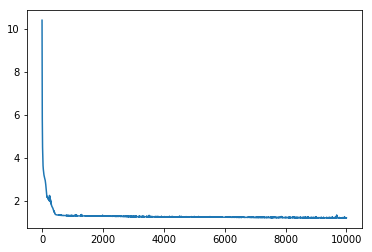

In [12]:
plt.plot(hist.history["loss"])

In [13]:
x = np.arange(-15.0, 15.0, 0.2)
y = np.arange(-15.0, 15.0, 0.2)
X, Y = np.meshgrid(x, y)
Z = model_train.predict([X.flatten().reshape((-1,1)), Y.flatten().reshape((-1,1))])
Z = Z.reshape(X.shape)

In [14]:
Z.shape

(150, 150)

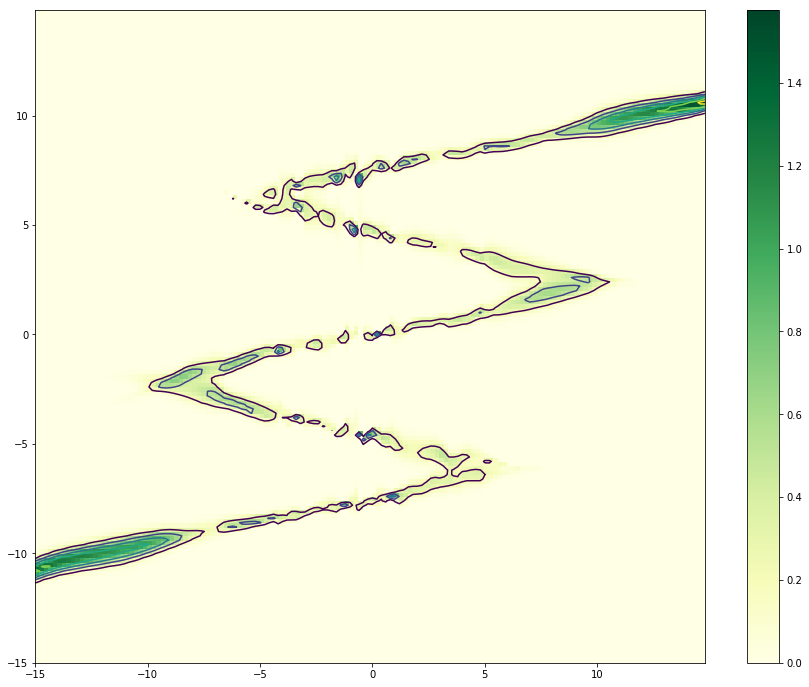

In [15]:
plt.figure(figsize=(15,12))
plt.pcolormesh(X,Y,Z,  cmap='YlGn')
plt.colorbar()
plt.contour(X, Y, Z)
plt.show()

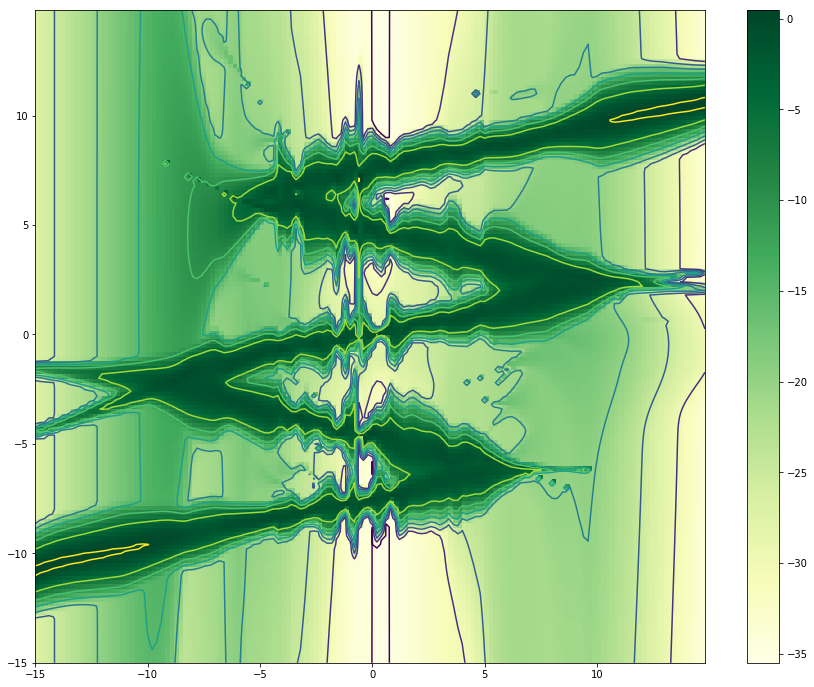

In [16]:
logZ = np.log(Z)
plt.figure(figsize=(15,12))
plt.pcolormesh(X,Y,logZ,  cmap='YlGn')
plt.colorbar()
plt.contour(X, Y, logZ)
plt.show()